In [71]:
# Implementation of Decision Tree Algorithm
# Using Shannon's Entropy

%matplotlib inline
import pandas as pd
import numpy as np
from math import log
import matplotlib.pyplot as plt

# Loading dataframe

fr = open("lenses.txt")
lenses_raw = [string.strip().split('\t') for string in fr.readlines()]
lenses_array = np.array(lenses_raw)
lenses_df = pd.DataFrame(data=lenses_array[:,:], columns=['age','prescript','astigmatic','tearRate','label_class'])
lenses_df.head()

,age,prescript,astigmatic,tearRate,label_class
0,young,myope,no,reduced,no lenses
1,young,myope,no,normal,soft
2,young,myope,yes,reduced,no lenses
3,young,myope,yes,normal,hard
4,young,hyper,no,reduced,no lenses


In [7]:
dataset = lenses_df
features = dataset.columns[:-1]

In [58]:
def calcShannonEnt(dataset):
    shannonEnt = 0.0
    numEntries = dataset.shape[0]
    LabelList = list(dataset.label_class)
    uniqueLabel = set(dataset.label_class)
    for label in uniqueLabel:
        LabelCount = LabelList.count(label)
        LabelProb = LabelCount / numEntries
        shannonEnt -= LabelProb * log(LabelProb,2)
    return shannonEnt  

def splitDataSet(feature, featVal, dataset):
    subData = dataset[dataset[feature]==featVal]
    return subData

def chooseBestFeature(dataset):
    features = dataset.columns[:-1]
    bestFeature = dataset.columns[0]
    baseEntropy = calcShannonEnt(dataset)
    bestinfoGain = 0.0
    for feature in features:
        feature_category_list = list(dataset[feature])
        unique_feature_category_list = set(feature_category_list)
        newEntropy = 0.0
        for category in unique_feature_category_list:
            subData = splitDataSet(feature, category, dataset)
            prob = subData.shape[0]/dataset.shape[0]
            newEntropy += prob*calcShannonEnt(subData)
            infogain = baseEntropy - newEntropy
            if(infogain > bestinfoGain):
                bestFeature = feature
                bestinfoGain = infogain
    return bestFeature

def majorityCnt(classList):
    vote = classList.value_counts()
    vote_name = vote.index[0]
    return vote_name

def createTree(dataset,features):
    classList = dataset['label_class']
    if len(set(list(classList))) == 1:
        return list(classList)[0]
    if dataset.shape[0] ==1:
        return majorityCnt(classList)
    bestFeature = chooseBestFeature(dataset)
    Tree = {bestFeature:{}}
    feature_category_list=list(dataset[bestFeature])
    unique_feature_category_list = set(feature_category_list)
    features = dataset.columns.drop(bestFeature)
    for category in unique_feature_category_list:
        subLabels = features
        Tree[bestFeature][category] = createTree(splitDataSet(bestFeature, category, dataset),subLabels)
    return Tree

In [92]:
Tree = createTree(dataset, features)
print(Tree)

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'yes': {'age': {'presbyopic': {'prescript': {'hyper': 'no lenses', 'myope': 'hard'}}, 'young': 'hard', 'pre': {'prescript': {'hyper': 'no lenses', 'myope': 'hard'}}}}, 'no': {'prescript': {'hyper': 'soft', 'myope': {'age': {'presbyopic': 'no lenses', 'young': 'soft', 'pre': 'soft'}}}}}}}}


In [98]:
'''
Created on Oct 14, 2010

@author: Peter Harrington
'''

decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")

arrow_args = dict(arrowstyle="<-")

def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            numLeafs += getNumLeafs(secondDict[key])
        else:   numLeafs +=1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:   thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,  xycoords='axes fraction',
             xytext=centerPt, textcoords='axes fraction',
             va="center", ha="center", bbox=nodeType, arrowprops=arrow_args )
    
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, va="center", ha="center", rotation=30)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def createPlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

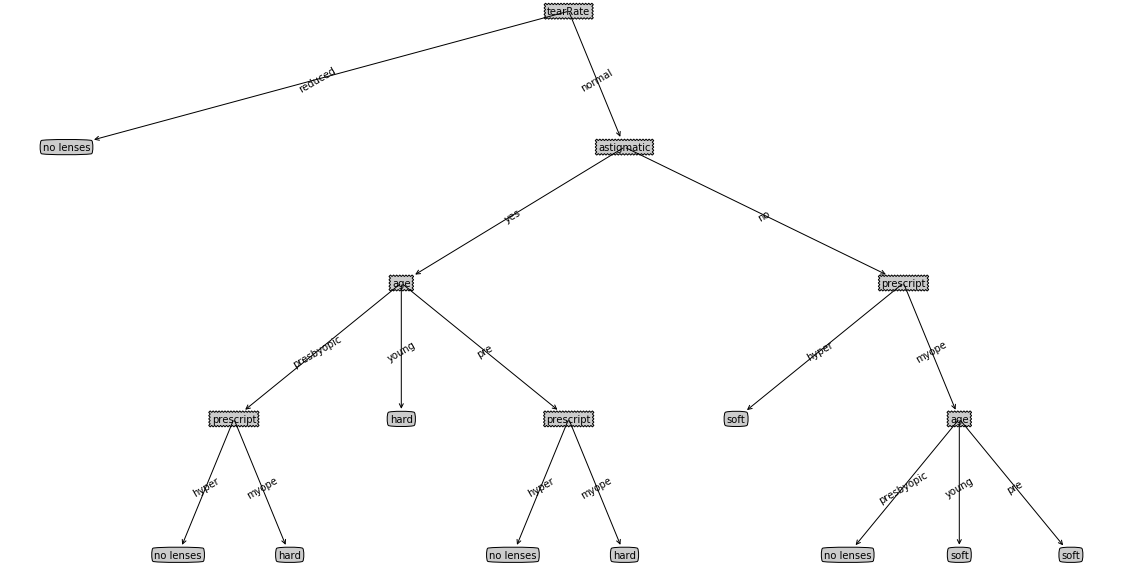

In [97]:
plt.figure(figsize= (20,10))
createPlot(Tree)